In [38]:
import numpy as np
import pandas as pd
import torch
import sys
import os
import pydicom

sys.path.insert(1, '../util/')
import preprocessing_util as util

In [56]:
def preprocess(data_dir, dest_dir, resample_resolution=[2,2,2]):
    train_images_dir = os.path.join(data_dir, 'train_images/')
    train_label_coordinates_dir = os.path.join(data_dir, 'train_label_coordinates.csv')
    train_series_descriptions_dir = os.path.join(data_dir, 'train_series_descriptions.csv')
    train_labels_dir = os.path.join(data_dir, 'train.csv')
    
    studies = os.listdir(train_images_dir)
    
    dest_data_dir = os.path.join(dest_dir, f'resampled-{resample_resolution[0]}mm_resolution')
    if not os.path.exists(dest_data_dir):
        os.makedirs(dest_data_dir)
    
    for study in studies:
    # for study in ['2780669808']:
        series_ids = os.listdir(os.path.join(train_images_dir, study))
        
        # Get the Severity Label data for this study (one-hot encoded)
        labels = util.load_label_data(train_labels_dir, int(study))
        print(labels)
        for series in series_ids:
        # for series in ['2149514139']:
            scan = util.load_sample(train_images_dir, study, series)
            
            # Skip this series if it has an error
            if not util.check_valid_scan(scan) :
                print(f'Skipping study {study} series {series}, multiple scans dumped in same directory')
                continue

            # Get the coordinate data for this series
            coord_data, coordinate_data_mask = util.load_coord_data(train_label_coordinates_dir, int(series))

            # Stack the scan together
            slices = np.stack([s.pixel_array for s in scan], dtype=np.float32)
            
            # Resample the Images and Coordinates to new resolution
            resampled_image, resampled_coord_data, new_spacing = util.resample_with_coordinates( slices , scan, coord_data, resample_resolution)
            
            # Transform Sagittal data to Axial Plane
            # orientation = util.get_series_orientation(train_series_descriptions_dir, int(series))
            # if 'sagittal' in orientation.lower():
            #     resampled_image, resampled_coord_data = util.sagittal_to_axial(resampled_image, resampled_coord_data)
            
            resampled_coord_data = np.array(resampled_coord_data, dtype=np.float32)
            
            #--------------------------
            # Cropping will be done during data augmentation at runtime. Leaving this all here for now to clean later
            #--------------------------
            
            # crop / zero-pad data
            # cropped_image, dim_diffs = util.crop_or_pad_image(resampled_image, final_dimensions)
            
            # dim_adjustments = [dim[0] for dim in dim_diffs]
            # cropped_coords, in_bounds_coords_mask = util.adjust_coordinates(resampled_coord_data, dim_adjustments, final_dimensions)
            
            # OOB_coords = [ data_mask == 1 and bounds_mask == 0 for data_mask, bounds_mask in zip(coordinate_data_mask, in_bounds_coords_mask)]
            # for clo in np.array(util.condition_level_order)[OOB_coords]:
            #     print(f'series {series} {clo} Out of Bounds after cropping')
            
            #--------------------------

            # combine masks
            mask = coordinate_data_mask #* in_bounds_coords_mask
            
            # Mask the labels to only predict labels that this scan determines
            assert labels.shape[0] == 25
            series_label_data = [ [0,0,0,1] if mask[i] == 0 else labels[i] for i in range(25)]
            series_label_data = np.array(series_label_data)

            #Exports: image, coordinates, labels, mask
            
            if not os.path.exists(os.path.join(dest_data_dir, study)):
                os.makedirs(os.path.join(dest_data_dir, study))
            if not os.path.exists(os.path.join(dest_data_dir, study, series)):
                os.makedirs(os.path.join(dest_data_dir, study, series))
            
            export_dest = os.path.join(dest_data_dir, study, series)
            
            assert type(resampled_image) == np.ndarray
            assert type(resampled_coord_data) == np.ndarray
            assert type(series_label_data) == np.ndarray
            assert type(mask) == np.ndarray
            np.save(os.path.join(export_dest,f'{series}_image.npy'), resampled_image)
            np.save(os.path.join(export_dest,f'{series}_coordinates.npy'), resampled_coord_data)
            np.save(os.path.join(export_dest,f'{series}_labels.npy'), series_label_data)
            np.save(os.path.join(export_dest,f'{series}_mask.npy'), mask)
    return


In [57]:
data_dir = '../data/'
dest_dir = '../preprocessing/datasets/'

# preprocess(data_dir, dest_dir, resample_resolution=[1.0,1.0,1.0])
# preprocess(data_dir, dest_dir, resample_resolution=[1.5,1.5,1.5])
# preprocess(data_dir, dest_dir, resample_resolution=[2.0,2.0,2.0])
# preprocess(data_dir, dest_dir, resample_resolution=[2.5,2.5,2.5])
# preprocess(data_dir, dest_dir, resample_resolution=[3.0,3.0,3.0])


[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]]


In [1]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import pydicom

sys.path.insert(1, '../util/')
import preprocessing_util as util
import augmentation as aug


def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [2]:
def plot_roi(volume, coords, idx=0):
    # print(coord[0])
    img = volume[int(coords[idx,0])]
    slice_coords = []
    for coord in coords:
        if coord[0] == coords[idx,0]:
            slice_coords.append(coord)
    # plt.scatter(x=[coord[1] for coord in slice_coords], y=[coord[2] for coord in slice_coords], c='r', s=40)
    plt.scatter(x=coords[idx,2], y=coords[idx,1])
    plt.imshow(img, cmap=plt.cm.bone)
    plt.show()
#Axial T2 
#Sagittal T1: (0,1,2) (z,x,y)
#Sagittal T2/STIR


In [11]:
#Axial T2
volume = np.load('datasets/resampled-2.0mm_resolution/10728036/142859125/142859125_image.npy')
coords = np.load('datasets/resampled-2.0mm_resolution/10728036/142859125/142859125_coordinates.npy')
mask   = np.load('datasets/resampled-2.0mm_resolution/10728036/142859125/142859125_mask.npy')
labels = np.load('datasets/resampled-2.0mm_resolution/10728036/142859125/142859125_labels.npy')

volume = aug.normalize_volume(volume)

In [3]:
#Sagittal T1
volume = np.load('datasets/resampled-2.0mm_resolution/10728036/2399638375/2399638375_image.npy')
coords = np.load('datasets/resampled-2.0mm_resolution/10728036/2399638375/2399638375_coordinates.npy')
mask   = np.load('datasets/resampled-2.0mm_resolution/10728036/2399638375/2399638375_mask.npy')
labels = np.load('datasets/resampled-2.0mm_resolution/10728036/2399638375/2399638375_labels.npy')

# volume = aug.normalize_volume(volume)

In [4]:
#Sagittal T1
volume = np.load('datasets/resampled-2.0mm_resolution/74294498/3485741709/3485741709_image.npy')
coords = np.load('datasets/resampled-2.0mm_resolution/74294498/3485741709/3485741709_coordinates.npy')
mask   = np.load('datasets/resampled-2.0mm_resolution/74294498/3485741709/3485741709_mask.npy')
labels = np.load('datasets/resampled-2.0mm_resolution/74294498/3485741709/3485741709_labels.npy')

# volume = aug.normalize_volume(volume)

In [33]:
#Sagittal T2/STIR
volume = np.load('datasets/resampled-2.0mm_resolution/10728036/3491739931/3491739931_image.npy')
coords = np.load('datasets/resampled-2.0mm_resolution/10728036/3491739931/3491739931_coordinates.npy')
mask   = np.load('datasets/resampled-2.0mm_resolution/10728036/3491739931/3491739931_mask.npy')
labels = np.load('datasets/resampled-2.0mm_resolution/10728036/3491739931/3491739931_labels.npy')

volume = aug.normalize_volume(volume)

In [11]:
#Sagittal T2/STIR
volume = np.load('datasets/resampled-2.0mm_resolution/283265383/221289021/221289021_image.npy')
coords = np.load('datasets/resampled-2.0mm_resolution/283265383/221289021/221289021_coordinates.npy')
mask   = np.load('datasets/resampled-2.0mm_resolution/283265383/221289021/221289021_mask.npy')
labels = np.load('datasets/resampled-2.0mm_resolution/283265383/221289021/221289021_labels.npy')

volume = aug.normalize_volume(volume)

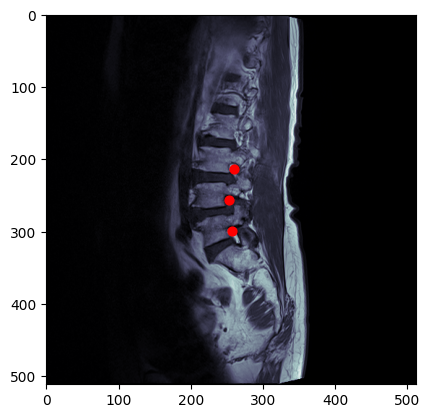

In [4]:
# img = pydicom.dcmread('../data/train_images/10728036/142859125/8.dcm').pixel_array
# plt.scatter(x=[251.0579151], y=[290.5559846], c='r', s=40)
# Left Subarticular Stenosis L1/L2 (n=20)

# img = pydicom.dcmread('../data/train_images/10728036/2399638375/6.dcm').pixel_array
# plt.scatter(x=[275.019851], y=[379.5533499], c='r', s=40)
# Right Neural Foraminal Narrowing L5/S1 (n=9)

img = pydicom.dcmread('../data/train_images/74294498/3485741709/4.dcm').pixel_array
plt.scatter(x=[259.7261104, 252.9024372,257.6016153], y=[213.7253725,255.9235412,299.7825367], c='r', s=40)
# Right Neural Foraminal Narrowing L5/S1 (n=9)

# img = pydicom.dcmread('../data/train_images/10728036/3491739931/11.dcm').pixel_array
# plt.scatter(x=[297.4204793], y=[148.9150327], c='r', s=40)
# Spinal Canal Stenosis L1/L2


plt.imshow(img, cmap=plt.cm.bone)
plt.show()

[35.36842 84.986   40.20649]


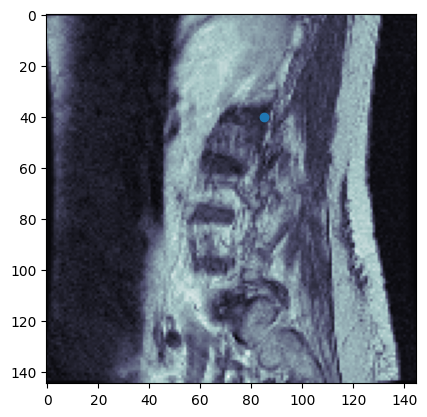

In [14]:
n = 10
# plot_roi(volume, coords, n)
# rotated_volume, rotated_coords = aug.rotate_volume_and_coords(volume, coords, 0, 1)
# rotated_volume, rotated_coords = aug.rotate_volume_and_coords(rotated_volume, rotated_coords, 90, 1)
# rotated_volume, rotated_coords = aug.rotate_volume_and_coords(rotated_volume, rotated_coords, 90, 0)
print(coords[n])
plot_roi(volume, coords, n)
# plot_roi(volume, coords, n)

[35.36842 84.986   40.20649]
[41.56652862 68.40610743 37.37538524]
------------
(48, 145, 145)
(56, 117, 135)


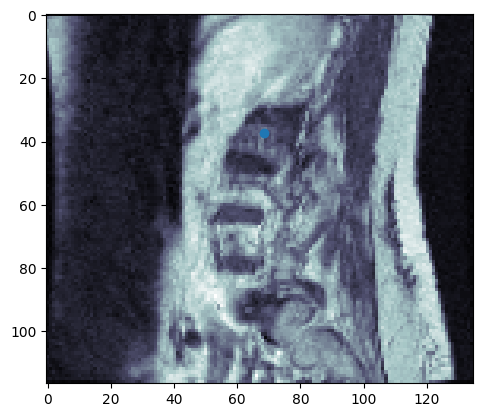

[68.40610743 37.37538524]


In [42]:
norm_vol = aug.normalize_volume(volume)
noised_vol = aug.gaussian_noise(norm_vol, 0.1)
max_scale = 0.5
# scales = [1.0,2.0,1.0]
# scaled_vol, scaled_coords, scales = aug.scale_volume(noised_vol, coords, [1.0,1.5,2.0])
scaled_vol, scaled_coords, scales = aug.scale_volume(noised_vol, coords, 0.2)
# scaled_coords *= scale

print(coords[n])
print(scaled_coords[n])
print('------------')
print(volume.shape)
print(scaled_vol.shape)

new_shape = [200,200,200]
max_shift = 40
# cropped_vol, cropped_coords, labels, final_mask = aug.random_shift_and_crop(noised_vol, coords, labels, mask, new_shape, max_shift)
# print(coords[n])
# print(scaled_coords[n])
# print(scales)
# print(volume.shape)
# print(scaled_vol.shape)

out_vol = scaled_vol
out_coords = scaled_coords
# out_coords = coords * [1 / scales[0], 1 / scales[1], 1 / scales[2]]

plot_roi(out_vol, out_coords, n)
idx = int(out_coords[n,0])
coord = out_coords[n,1:]
slice = out_vol[idx]
print(coord)
# plot_heatmap_with_points(slice, [coord], 'slice')




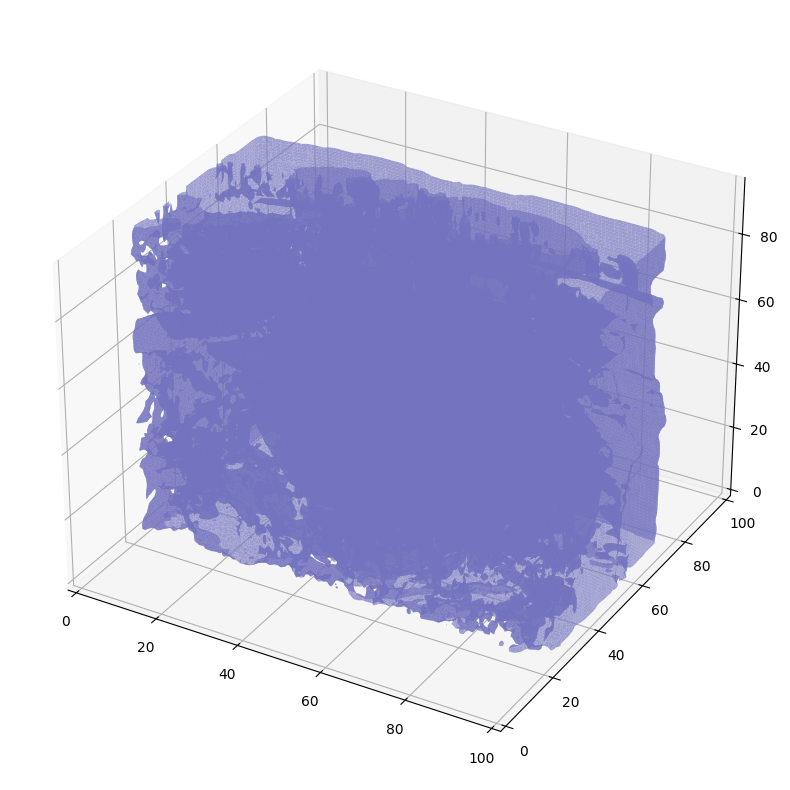

In [23]:
plot_3d(np.load('datasets/resampled-2.0mm_resolution/4003253/2448190387/2448190387_image.npy'), 70)

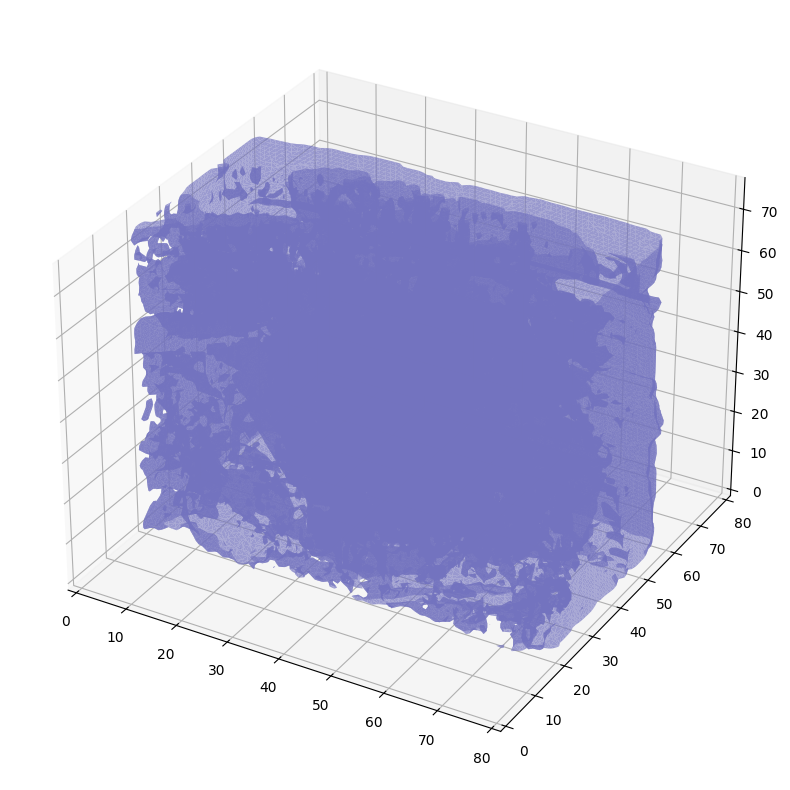

In [24]:
plot_3d(np.load('datasets/resampled-2.5mm_resolution/4003253/2448190387/2448190387_image.npy'), 70)

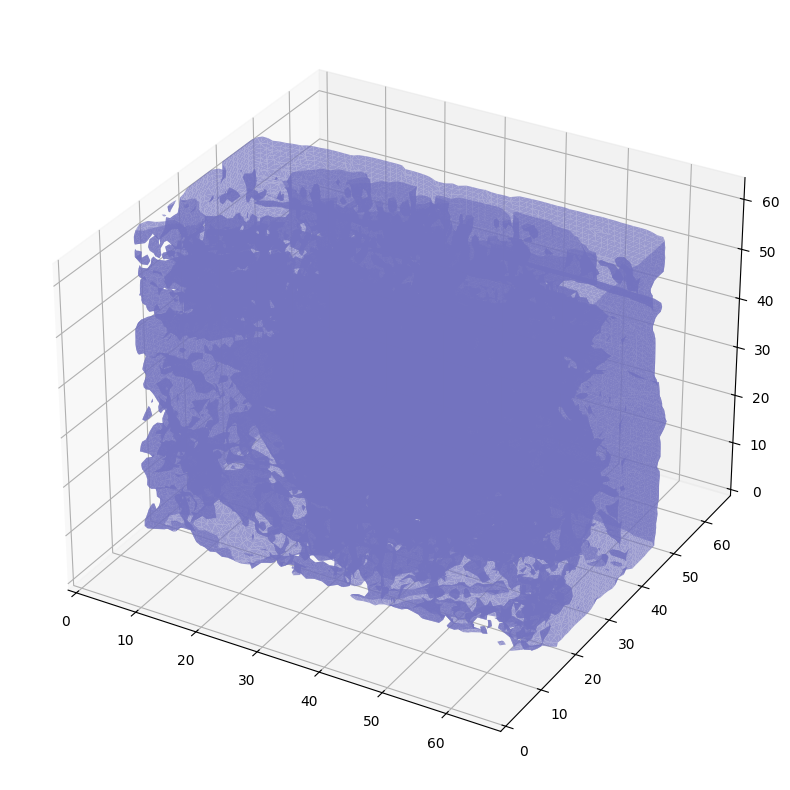

In [25]:
plot_3d(np.load('datasets/resampled-3.0mm_resolution/4003253/2448190387/2448190387_image.npy'), 70)

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_with_points(array, points, title):
    """
    Plot a 2D heatmap of the given array and overlay points on top of it.

    Parameters:
    - array: 2D numpy array to be plotted as a heatmap.
    - points: List of points to be overlaid, each point is a tuple (x, y).
    - title: Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(array, cmap='viridis', origin='upper')
    
    for point in points:
        plt.scatter(point[0], point[1], color='red', s=100, edgecolor='black')
    
    plt.title(title)
    plt.show()